# Visualization of pagerank

In [1]:
# Add 'graph' environment to PATH
import sys
sys.path.append('/home/ski/anaconda3/envs/graph/lib/python3.8/site-packages')

# User defined functions
import base_methods
from base_methods import load_the_csvs
import graph_methods
from graph_methods import network_by_date, load_vertices, find_p1_affiliations, load_edges, make_graph
import feature_methods
from feature_methods import feature_creation, add_pagerank, add_weighted_pagerank, add_shortest_path
from feature_methods import add_weighted_shortest_path, add_kcore, add_degree, add_triangle
from feature_methods import update_pagerank_weight, update_pagerank_reset_prob, update_pagerank_prev_to_current
from feature_methods import sum_weight, make_pagerank_zero, update_l1_delta, normalize_weight, pagerank_weighted

# Import data analysis packages
import numpy as np
import pandas as pd
import csv
import warnings
import os
import time
import math
from importlib import reload
from functools import reduce
from datetime import datetime
warnings.filterwarnings('ignore')

# Import plotting packages
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
sns.set(font_scale=1.3)
sns.set_style("white") 

# Graph
import networkx as nx
from pyvis.network import Network
import turicreate
from turicreate import pagerank, kcore, degree_counting, shortest_path, connected_components, triangle_counting
from turicreate import SFrame, SGraph, SArray, load_sgraph, aggregate 

## Loading data

In [ ]:
# Store path to notebook
PWD = '/home/ski/Desktop/crunchbase-p1-machine-learning'

# Set paths to data folders
INPUT = PWD + '/files/csv/'
OUTPUT = PWD + '/files/output/'
NETWORK_SFRAMES = OUTPUT + 'network_sframes/'
CRUNCHBASE_GRAPHS = OUTPUT + 'CrunchbaseGraphs/'
SAMPLE_VERTICES = OUTPUT + 'sample_vertices/'
MODEL_CSVS = OUTPUT + 'model_csvs/'

# Make sure those folders exist already
!mkdir {INPUT}
!mkdir {OUTPUT}
!mkdir {NETWORK_SFRAMES}
!mkdir {NETWORK_SFRAMES}p1
!mkdir {NETWORK_SFRAMES}cb
!mkdir {NETWORK_SFRAMES}model
!mkdir {NETWORK_SFRAMES}np1
!mkdir {CRUNCHBASE_GRAPHS}
!mkdir {SAMPLE_VERTICES}
!mkdir {MODEL_CSVS}

# Load
df = load_the_csvs(loc=OUTPUT, data=['organizations_merged'], verbose=True)
print('Pledge 1% UUID: {}'.format(df[df['name']=='Pledge 1%'].uuid.values[0]))

# Loading SFrames
lst_of_frames = []
for val in ['cb','p1']:
    lst = []
    for idx in range(12):
        lst.append(SFrame(data=NETWORK_SFRAMES+'{}/{}_df.csv'.format(val, idx)))
    lst_of_frames.append(lst)
cb_sframes,p1_sframes = lst_of_frames

# List of Pledge 1% uuids for sampling
p1_companies_uuid = []
p1_companies_uuid.extend(list(p1_sframes[0]['uuid'].unique()))
p1_companies_uuid.extend(list(p1_sframes[1]['uuid'].unique()))
p1_companies_uuid = list(set(p1_companies_uuid))

## Loading SGraphs
- `Cruncbase_1Way_MultiEdge`: Directed SGraph, one way, parallel edges (**MAIN GRAPH**)

- `Cruncbase_1Way_SingleEdge`: Directed SGraph, one way, **no parallel edges**

- `Crunchbase_2Ways_MultiEdge`: Directed SGraph, **two ways**, parallel edges (**WHEN NEEDED FOR FEATURE CALCULATIONS**)
    
- `Crunchbase_2Ways_SingleEdge`: Directed SGraph, two ways, **no parallel edges**
    
There here are 4 additional graphs with weights added! See complete list in code cell.

In [ ]:
# Load
cb1 = load_sgraph(CRUNCHBASE_GRAPHS + 'Cruncbase_1Way_MultiEdge')

# With Weights
cb1w = load_sgraph(CRUNCHBASE_GRAPHS + 'Cruncbase_1Way_MultiEdge_Weighted')

# Dataframe vertices from different Crunchbase graphs
DEGREE_5_vertices = pd.read_csv(SAMPLE_VERTICES+'/DEGREE_5_Pick_Sample_Companies_From_Here.csv')
DEGREE_4_vertices = pd.read_csv(SAMPLE_VERTICES+'DEGREE_4_Pick_Sample_Companies_From_Here.csv')

# List of graphs used in loop
list_of_graphs = [cb1,cb1w]

# Visualization of pagerank

In [42]:
# Coordinating -- for loading in graphs
vertex_type_list = ['cb_smol_D4', 'cb_smol_D5']
feat_graph_map = {'pagerank':['cb1'], 
                  'kcore':['cb0','cb1','cb2','cb3'],
                  'degree':['cb0','cb1'], 
                  'triangle':['cb0','cb1'],
                  'shortest':['cb1', 'cb3'], 
                  'shortest_weight':['cb1w', 'cb3w'],
                  'pagerank_weight':['cb1w']}

# Setting up loop
neighborhoods_name = ['Model_DF_D4', 'Model_DF_D5']
neighborhoods = [DEGREE_4_vertices, DEGREE_5_vertices]
neighborhoods_dict = dict(zip(neighborhoods_name,neighborhoods))

In [93]:
from turicreate import pagerank
from functools import reduce

# Mapping for this function
sgraph_idx_assign = {0:'cb1', 1:'cbw1'}

if not len(sgraph_idx_assign.items())==len(feat_graph_map['pagerank']):
    print('THE ASSIGNMENT DOES NOT MATCH NUMBER OF GRAPHS')

for vertex_type in vertex_type_list:
    lst_of_frames = []
    for idx,smol in enumerate(feat_graph_map['pagerank']):
        print('CaLcUlAtInG pAgeRaNk for graph {}, in graph neighborhood {}'.format(sgraph_idx_assign[idx].upper(),vertex_type.upper()))
        path = 'ModelGraphs/test/{}_{}'.format(vertex_type,smol)
        graph = load_sgraph(path)
        pr = pagerank.create(graph, verbose=False)
        pr_sframe = pr['pagerank']
        pr_out = pr_sframe.sort('pagerank', ascending=False)
        for idx, uuid in enumerate(pr_out['__id']):
            if idx+1 < 10:
                print('{}. {}'.format(idx+1, graph.get_vertices(ids=uuid)['name', 'p1_tag'][0]))
            else:
                break
        # Modifying output SFrame
        pr_df = pd.DataFrame(pr_sframe)
        pr_df = pr_df.drop('delta', axis=1)
        pr_df = pr_df[pr_df['__id'].isin(model_uuids_dict[vertex_type])].reset_index(drop=True)
        pr_df = pr_df.rename({'pagerank':'pr_{}'.format(idx)}, axis=1)

        # Save to temp lst_of_frames
        lst_of_frames.append(pr_df)
    
    PR_DF = reduce(lambda df1,df2: pd.merge(df1,df2,on='__id'), lst_of_frames)
    vertex_df_map[vertex_type] = pd.merge(vertex_df_map[vertex_type], PR_DF, on='__id', how='outer')

THE ASSIGNMENT DOES NOT MATCH NUMBER OF GRAPHS
CaLcUlAtInG pAgeRaNk for graph CB1, in graph neighborhood CB_SMOL_D4
1. {'name': 'EASME - EU Executive Agency for SMEs', 'p1_tag': 0}
2. {'name': 'Y Combinator', 'p1_tag': 0}
3. {'name': 'Techstars', 'p1_tag': 1}
4. {'name': '500 Startups', 'p1_tag': 0}
5. {'name': 'MassChallenge', 'p1_tag': 0}
6. {'name': 'Microsoft', 'p1_tag': 0}
7. {'name': 'SOSV', 'p1_tag': 0}
8. {'name': 'Crowdcube', 'p1_tag': 0}
9. {'name': 'Venture Kick', 'p1_tag': 0}
CaLcUlAtInG pAgeRaNk for graph CB1, in graph neighborhood CB_SMOL_D5
1. {'name': 'EASME - EU Executive Agency for SMEs', 'p1_tag': 0}
2. {'name': 'Y Combinator', 'p1_tag': 0}
3. {'name': 'Techstars', 'p1_tag': 1}
4. {'name': '500 Startups', 'p1_tag': 0}
5. {'name': 'MassChallenge', 'p1_tag': 0}
6. {'name': 'Microsoft', 'p1_tag': 0}
7. {'name': 'SOSV', 'p1_tag': 0}
8. {'name': 'Crowdcube', 'p1_tag': 0}
9. {'name': 'Venture Kick', 'p1_tag': 0}


In [94]:
#################################################################################
# Weighted pagerank
# Mapping for this function
sgraph_idx_assign = {0:'cb1w'}

if not len(sgraph_idx_assign.items())==len(feat_graph_map['pagerank_weight']):
    print('THE ASSIGNMENT DOES NOT MATCH NUMBER OF GRAPHS')

for vertex_type in vertex_type_list:
    lst_of_frames = []
    for idx,smol in enumerate(feat_graph_map['pagerank_weight']):
        print('CaLcUlAtInG wEiGhTeD pAgeRaNk for graph {}, in graph neighborhood {}'.format(sgraph_idx_assign[idx].upper(),vertex_type.upper()))
        path = 'ModelGraphs/test/{}_{}'.format(vertex_type,smol)
        graph = load_sgraph(path)
        pr_w = pagerank_weight(graph)
        pr_w_sframe = pr_w['__id', 'pagerank']
        pr_out=pr_w_sframe.sort('pagerank', ascending=False)
        pr_out.head()
        for idx, uuid in enumerate(pr_out['__id']):
            if idx+1 < 50:
                print('{}. {}'.format(idx+1, graph.get_vertices(ids=uuid)['name', 'p1_tag'][0]))
            else:
                break
        # Modifying output SFrame
        pr_w_df = pd.DataFrame(pr_w_sframe)
        pr_w_df = pr_w_df[pr_w_df['__id'].isin(model_uuids_dict[vertex_type])].reset_index(drop=True)
        pr_w_df = pr_w_df.rename({'pagerank_weight':'w_pr_{}'.format(idx)}, axis=1)
        
        # Save to temp lst_of_frames
        lst_of_frames.append(pr_w_df)
    
    PR_W_DF = reduce(lambda df1,df2: pd.merge(df1,df2,on='__id'), lst_of_frames)
    vertex_df_map[vertex_type] = pd.merge(vertex_df_map[vertex_type], PR_W_DF, on='__id', how='outer')

CaLcUlAtInG wEiGhTeD pAgeRaNk for graph CB1W, in graph neighborhood CB_SMOL_D4
Iteration 0: total pagerank changed in L1 = 206964.762212
Iteration 1: total pagerank changed in L1 = 8813.620559
Iteration 2: total pagerank changed in L1 = 0.000000
Weighted pagerank finished in: 148.479361 secs
1. {'name': 'Cultivator', 'p1_tag': 0}
2. {'name': 'LEANLAB Education', 'p1_tag': 0}
3. {'name': 'Foellinger Foundation', 'p1_tag': 0}
4. {'name': 'Jacana Partners', 'p1_tag': 0}
5. {'name': 'International Centre for Entrepreneurship and Technology', 'p1_tag': 0}
6. {'name': 'GENUINE & PROFOUND', 'p1_tag': 0}
7. {'name': 'RUANS', 'p1_tag': 0}
8. {'name': 'FBN Capital', 'p1_tag': 0}
9. {'name': 'RevvX Hardware / IOT Accelerator', 'p1_tag': 0}
10. {'name': 'Midinvest Management', 'p1_tag': 0}
11. {'name': 'INGENIUM Poland Fund', 'p1_tag': 0}
12. {'name': 'Hengda Gufen', 'p1_tag': 0}
13. {'name': 'Solidus Investment', 'p1_tag': 0}
14. {'name': 'Cardon Outreach', 'p1_tag': 0}
15. {'name': 'Phandeeyar A

### Convert to NetworkX graph

In [96]:
p1 = load_edges(p1_sframes, load_vertices(p1_sframes,SGraph()), p1_affiliations=[])
p1 = load_edges(p1_sframes, p1, p1_affiliations=[], reverse=True)

# Get list of edge fields
graph_edge_fields = p1.get_edge_fields()

# Create temporary edge attribute that you'll use in aggregate function
p1.edges['combined'] = p1.edges['__id']+','+p1.edges['status']+','+p1.edges['__src_id']+','+p1.edges['__dst_id']

# Before comparison
before = p1.summary()
before_pri = p1.get_edges(fields={'status':'primary'}).shape[0]
before_sec = p1.get_edges(fields={'status':'secondary'}).shape[0]
before_ter = p1.get_edges(fields={'status':'tertiary'}).shape[0]

# Select one value of duplicated rows th
p1 = SGraph(p1.vertices, p1.edges.groupby(graph_edge_fields, {'combined': aggregate.SELECT_ONE('combined')}))

# After comparison
after = p1.summary()
after_pri = p1.get_edges(fields={'status':'primary'}).shape[0]
after_sec = p1.get_edges(fields={'status':'secondary'}).shape[0]
after_ter = p1.get_edges(fields={'status':'tertiary'}).shape[0]

# Output
print('Remove duplicates from Crunchbase graph')
print('\nNode change: {:,} --> {:,}'.format(before['num_vertices'], after['num_vertices']))
print('Edge change: {:,} --> {:,}'.format(before['num_edges'], after['num_edges']))
print('\nPRIMARY Edge change: {:,} --> {:,}'.format(before_pri,after_pri))
print('SECONDARY Edge change: {:,} --> {:,}'.format(before_sec,after_sec))
print('TERTIARY Edge change: {:,} --> {:,}'.format(before_ter,after_ter))

del p1.edges['combined']

Remove duplicates from Crunchbase graph

Node change: 61,100 --> 61,100
Edge change: 257,276 --> 242,300

PRIMARY Edge change: 54,782 --> 54,760
SECONDARY Edge change: 85,388 --> 72,682
TERTIARY Edge change: 117,106 --> 114,858


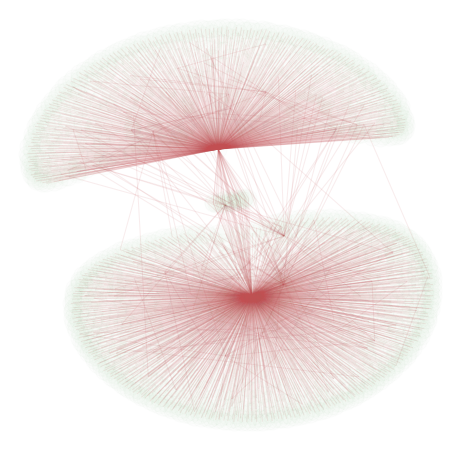

In [99]:
# IMPORT PACKAGE
from networkx.drawing.nx_agraph import graphviz_layout

# LOAD GRAPH
cb = load_sgraph('CrunchbaseGraphs/Crunchbase_2Ways_MultiEdge')
smol_5 = cb.get_neighborhood(ids=['6acfa7da-1dbd-936e-d985-cf07a1b27711', 
                                  '71d51015-1800-ed61-8bc3-8dca49caec15', 
                                  '315e1e59-3784-ab73-9c4a-447d2616ae82', 
                                  'fd80725f-53fc-7009-9878-aeecf1e9ffbb', 
                                  '3718597a-dd39-6661-3630-09cdd43bcac2'], radius=1, full_subgraph=True)
smol_2 = cb.get_neighborhood(ids=['6acfa7da-1dbd-936e-d985-cf07a1b27711',
                                  '71d51015-1800-ed61-8bc3-8dca49caec15'], radius=1, full_subgraph=True)

# USE SINGLE EDGE GRAPH HERE
edge_fields_list_smol_2 = smol_2.get_edge_fields()
edges_smol_2 = [(row['__src_id'], row['__dst_id'], dict(list(row.items())[2:])) for row in smol_2.edges[edge_fields_list_smol_2]]
vertices_fields_list_smol_2 = smol_2.get_vertex_fields()
nodes_smol_2 = [(row['__id'], dict(list(row.items())[1:])) for row in smol_2.vertices[vertices_fields_list_smol_2]]
cb_nx_ = nx.Graph()
cb_nx_.add_nodes_from(nodes_smol_2)
cb_nx_.add_edges_from(edges_smol_2)

edge_fields_list = smol_5.get_edge_fields()
edges = [(row['__src_id'], row['__dst_id'], dict(list(row.items())[2:])) for row in smol_5.edges[edge_fields_list]]
vertices_fields_list = smol_5.get_vertex_fields()
nodes = [(row['__id'], dict(list(row.items())[1:])) for row in smol_5.vertices[vertices_fields_list]]
cb_nx = nx.Graph()
cb_nx.add_nodes_from(nodes)
cb_nx.add_edges_from(edges)

# TOP 2 COMPANIES W RADIUS 1
plt.figure(figsize=(8,8)) 
pos = graphviz_layout(cb_nx_)
plt.axis('off')
nx.draw_networkx_nodes(cb_nx_,pos,node_color='g',alpha = 0.01)  # draws nodes
nx.draw_networkx_edges(cb_nx_,pos,edge_color='r',alpha = 0.1)  # draws edges
plt.show()

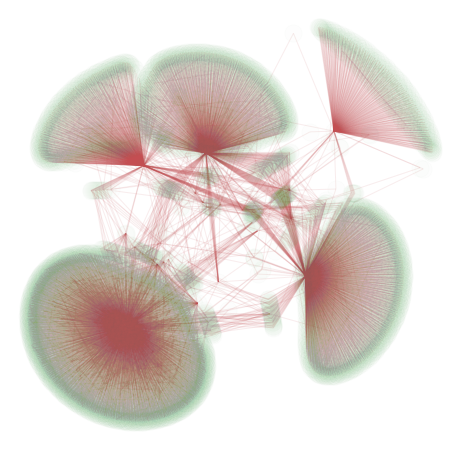

In [100]:
# TOP 5 COMPANIES W RADIUS 1
plt.figure(figsize=(8,8)) 
pos = graphviz_layout(cb_nx)
plt.axis('off')
nx.draw_networkx_nodes(cb_nx,pos,node_color='g',alpha = 0.01)  # draws nodes
nx.draw_networkx_edges(cb_nx,pos,edge_color='r',alpha = 0.1)  # draws edges
plt.show()